In [4]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold,StratifiedKFold,train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score
from lightgbm import LGBMClassifier
import os
import eli5
from eli5.sklearn import PermutationImportance
from catboost import CatBoostClassifier

In [5]:
train_df=pd.read_csv('C:/Users/Aditya/Desktop/Kaggle Datasets/Janata Hack Cross Sell/train.csv')
test_df=pd.read_csv('C:/Users/Aditya/Desktop/Kaggle Datasets/Janata Hack Cross Sell/test.csv')
submission_df=pd.read_csv('C:/Users/Aditya/Desktop/Kaggle Datasets/Janata Hack Cross Sell/sample_submission.csv')

In [6]:
train_df.head(5)

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28,0,> 2 Years,Yes,40454,26,217,1
1,2,Male,76,1,3,0,1-2 Year,No,33536,26,183,0
2,3,Male,47,1,28,0,> 2 Years,Yes,38294,26,27,1
3,4,Male,21,1,11,1,< 1 Year,No,28619,152,203,0
4,5,Female,29,1,41,1,< 1 Year,No,27496,152,39,0


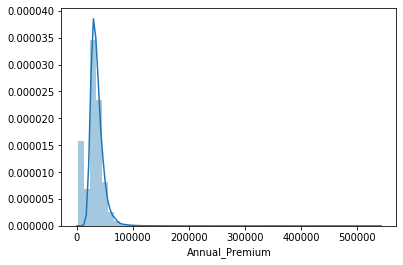

In [7]:
sns.distplot(train_df['Annual_Premium'])

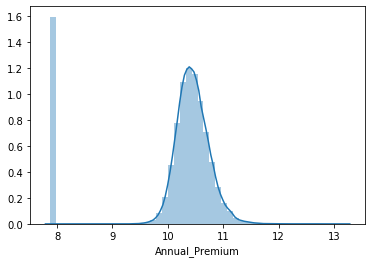

In [8]:
train_df['Annual_Premium']=np.log(train_df['Annual_Premium'])
sns.distplot(train_df['Annual_Premium'])

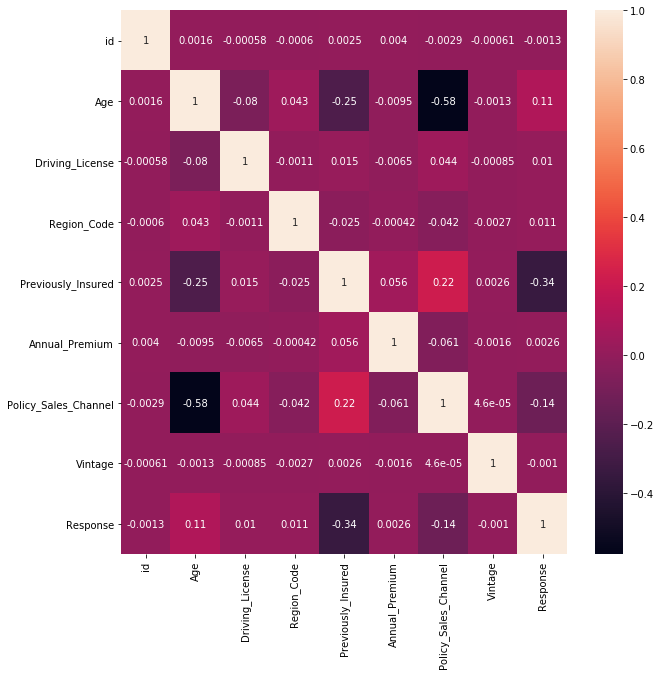

In [9]:
plt.figure(figsize=(10,10))
sns.heatmap(train_df.corr(),annot=True)

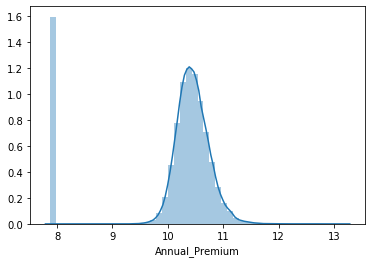

In [10]:
sns.distplot(train_df['Annual_Premium'])

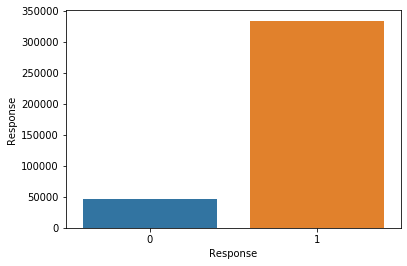

In [11]:
sns.barplot(train_df['Response'],train_df['Response'].value_counts())

## Adding Features for LGBM

In [12]:
train_df=train_df.drop_duplicates(subset=[ele for ele in list(train_df.columns) if ele not in ['id']])

In [13]:
train_df.shape

(380840, 12)

In [14]:
combine_set=pd.concat([train_df,test_df])

In [15]:
le=LabelEncoder()

In [16]:
combine_set['Gender']=le.fit_transform(combine_set['Gender'])
combine_set['Vehicle_Damage']=le.fit_transform(combine_set['Vehicle_Damage'])
combine_set['Vehicle_Age']=combine_set['Vehicle_Age'].map({'< 1 Year':0,'1-2 Year':1,'> 2 Years':2})

In [32]:
pd.set_option('display.max_columns', None)
combine_set.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response,Customer_term_in_year,Total_premium_Channelwise,Mean_premium_Channelwise,Maximum_premium_Channelwise,Min_premium_Channelwise,Total_premium_regionwise,Mean_premium_regionwise,Max_premium_regionwise,Min_premium_regionwise,Age_groups_region_wise,regionwise_channels,Channelwise_regions,Unique_customers_based_Vinatge,Region_wise_Vehicle_Age_premium,Region_wise_Vehicle_Age_premium_mean,Region_wise_Vehicle_Age_premium_max,Channel_wise_Vehicle_Age_premium,Channel_wise_Vehicle_Age_premium_mean,Channel_wise_Vehicle_Age_premium_max,Rank_regionwise_premium,Rank_mean_regionwise_premium,Rank_max_regionwise_premium,Rank_min_regionwise_premium
0,1,1,44,1,28.0,0,2,1,10.607921,26.0,217,1.0,0.594521,9.043676e+08,8488.526572,424578.0,7.874739,1.372002e+09,9671.725385,472042.0,7.874739,66,53.0,127.0,290,1.327976e+08,10414.677519,195863.0,8.945615e+07,9538.936537,195863.0,59233.0,59235.5,59238.0,59233.0
1,2,1,76,1,3.0,0,1,0,10.420375,26.0,183,0.0,0.501370,9.043676e+08,8488.526572,424578.0,7.874739,7.533820e+07,6103.718593,424578.0,7.874739,63,53.0,64.0,290,3.585642e+07,5799.194843,424578.0,7.614048e+08,8410.060324,424578.0,7150.0,7150.5,7151.0,7150.0
2,3,1,47,1,28.0,0,2,1,10.553049,26.0,27,1.0,0.073973,9.043676e+08,8488.526572,424578.0,7.874739,1.372002e+09,9671.725385,472042.0,7.874739,66,53.0,127.0,290,1.327976e+08,10414.677519,195863.0,8.945615e+07,9538.936537,195863.0,51635.0,51635.5,51636.0,51635.0
3,4,1,21,1,11.0,1,0,0,10.261826,152.0,203,0.0,0.556164,1.385023e+09,7719.489614,339396.0,7.874739,8.615454e+07,6990.226313,193637.0,7.874739,62,53.0,53.0,290,5.459438e+07,7437.926177,193637.0,1.301090e+09,7777.869087,339396.0,4383.0,4383.0,4383.0,4383.0
4,5,0,29,1,41.0,1,0,0,10.221796,152.0,39,0.0,0.106849,1.385023e+09,7719.489614,339396.0,7.874739,1.901158e+08,7793.868063,339396.0,7.874739,64,53.0,68.0,290,1.015146e+08,8003.989306,339396.0,1.301090e+09,7777.869087,339396.0,5920.0,5920.5,5921.0,5920.0


In [18]:
combine_set['Customer_term_in_year']=combine_set['Vintage']/365

In [20]:
combine_set['Total_premium_Channelwise']=combine_set.groupby(['Policy_Sales_Channel'])['Annual_Premium'].transform('sum')

In [23]:
combine_set['Mean_premium_Channelwise']=combine_set.groupby(['Policy_Sales_Channel'])['Annual_Premium'].transform('mean')
combine_set['Maximum_premium_Channelwise']=combine_set.groupby(['Policy_Sales_Channel'])['Annual_Premium'].transform('max')
combine_set['Min_premium_Channelwise']=combine_set.groupby(['Policy_Sales_Channel'])['Annual_Premium'].transform('min')

In [25]:
combine_set['Total_premium_regionwise']=combine_set.groupby(['Region_Code'])['Annual_Premium'].transform('sum')
combine_set['Mean_premium_regionwise']=combine_set.groupby(['Region_Code'])['Annual_Premium'].transform('mean')
combine_set['Max_premium_regionwise']=combine_set.groupby(['Region_Code'])['Annual_Premium'].transform('max')
combine_set['Min_premium_regionwise']=combine_set.groupby(['Region_Code'])['Annual_Premium'].transform('min')

In [26]:
combine_set['Age_groups_region_wise']=combine_set.groupby(['Region_Code'])['Age'].transform('nunique')
combine_set['regionwise_channels']=combine_set.groupby(['Policy_Sales_Channel'])['Region_Code'].transform('nunique')
combine_set['Channelwise_regions']=combine_set.groupby(['Region_Code'])['Policy_Sales_Channel'].transform('nunique')
combine_set['Unique_customers_based_Vinatge']=combine_set.groupby(['Region_Code','Policy_Sales_Channel'])['Vintage'].transform('nunique')

In [27]:
combine_set['Region_wise_Vehicle_Age_premium']=combine_set.groupby(['Region_Code','Vehicle_Age'])['Annual_Premium'].transform('sum')
combine_set['Region_wise_Vehicle_Age_premium_mean']=combine_set.groupby(['Region_Code','Vehicle_Age'])['Annual_Premium'].transform('mean')
combine_set['Region_wise_Vehicle_Age_premium_max']=combine_set.groupby(['Region_Code','Vehicle_Age'])['Annual_Premium'].transform('max')

In [28]:
combine_set['Channel_wise_Vehicle_Age_premium']=combine_set.groupby(['Policy_Sales_Channel', 'Vehicle_Age'])['Annual_Premium'].transform('sum')
combine_set['Channel_wise_Vehicle_Age_premium_mean']=combine_set.groupby(['Policy_Sales_Channel', 'Vehicle_Age'])['Annual_Premium'].transform('mean')
combine_set['Channel_wise_Vehicle_Age_premium_max']=combine_set.groupby(['Policy_Sales_Channel', 'Vehicle_Age'])['Annual_Premium'].transform('max')

In [29]:
#Rank Features
combine_set['Rank_regionwise_premium']=combine_set.groupby(['Region_Code'])['Annual_Premium'].rank(method='first',ascending=True)
combine_set['Rank_mean_regionwise_premium']=combine_set.groupby(['Region_Code'])['Annual_Premium'].rank(method='average',ascending=True)
combine_set['Rank_max_regionwise_premium']=combine_set.groupby(['Region_Code'])['Annual_Premium'].rank(method='max',ascending=True)
combine_set['Rank_min_regionwise_premium']=combine_set.groupby(['Region_Code'])['Annual_Premium'].rank(method='min',ascending=True)

In [33]:
combine_set['Rank_regionwise_diff']=combine_set['Rank_max_regionwise_premium']- combine_set['Rank_min_regionwise_premium']

In [34]:
combine_set['Rank_channelwise_premium']=combine_set.groupby(['Policy_Sales_Channel'])['Annual_Premium'].rank(method='first',ascending=True)
combine_set['Rank_mean_channelwise_premium']=combine_set.groupby(['Policy_Sales_Channel'])['Annual_Premium'].rank(method='average',ascending=True)
combine_set['Rank_max_channelwise_premium']=combine_set.groupby(['Policy_Sales_Channel'])['Annual_Premium'].rank(method='max',ascending=True)
combine_set['Rank_min_channelwise_premium']=combine_set.groupby(['Policy_Sales_Channel'])['Annual_Premium'].rank(method='min',ascending=True)

In [35]:
combine_set['Rank_channelwise_diff']=combine_set['Rank_max_channelwise_premium']- combine_set['Rank_min_channelwise_premium']

In [36]:
combine_set['Rank_Channel_wise_Vehicle_Age_Premium']=combine_set.groupby(['Policy_Sales_Channel','Vehicle_Age'])['Annual_Premium'].rank(method='first',ascending=True)
combine_set['Rank_Region_wise_Vehicle_Age_premium']=combine_set.groupby(['Region_Code','Vehicle_Age'])['Annual_Premium'].rank(method='first',ascending=True)
combine_set['Rank_Age_wise_premium']=combine_set.groupby(['Age'])['Annual_Premium'].rank(method='first',ascending=True)

In [37]:
combine_set.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response,Customer_term_in_year,Total_premium_Channelwise,Mean_premium_Channelwise,Maximum_premium_Channelwise,Min_premium_Channelwise,Total_premium_regionwise,Mean_premium_regionwise,Max_premium_regionwise,Min_premium_regionwise,Age_groups_region_wise,regionwise_channels,Channelwise_regions,Unique_customers_based_Vinatge,Region_wise_Vehicle_Age_premium,Region_wise_Vehicle_Age_premium_mean,Region_wise_Vehicle_Age_premium_max,Channel_wise_Vehicle_Age_premium,Channel_wise_Vehicle_Age_premium_mean,Channel_wise_Vehicle_Age_premium_max,Rank_regionwise_premium,Rank_mean_regionwise_premium,Rank_max_regionwise_premium,Rank_min_regionwise_premium,Rank_regionwise_diff,Rank_channelwise_premium,Rank_mean_channelwise_premium,Rank_max_channelwise_premium,Rank_min_channelwise_premium,Rank_channelwise_diff,Rank_Channel_wise_Vehicle_Age_Premium,Rank_Region_wise_Vehicle_Age_premium,Rank_Age_wise_premium
0,1,1,44,1,28.0,0,2,1,10.607921,26.0,217,1.0,0.594521,9.043676e+08,8488.526572,424578.0,7.874739,1.372002e+09,9671.725385,472042.0,7.874739,66,53.0,127.0,290,1.327976e+08,10414.677519,195863.0,8.945615e+07,9538.936537,195863.0,59233.0,59235.5,59238.0,59233.0,5.0,54268.0,54269.0,54270.0,54268.0,2.0,3771.0,4320.0,6187.0
1,2,1,76,1,3.0,0,1,0,10.420375,26.0,183,0.0,0.501370,9.043676e+08,8488.526572,424578.0,7.874739,7.533820e+07,6103.718593,424578.0,7.874739,63,53.0,64.0,290,3.585642e+07,5799.194843,424578.0,7.614048e+08,8410.060324,424578.0,7150.0,7150.5,7151.0,7150.0,1.0,36846.0,36848.0,36850.0,36846.0,4.0,31750.0,3554.0,637.0
2,3,1,47,1,28.0,0,2,1,10.553049,26.0,27,1.0,0.073973,9.043676e+08,8488.526572,424578.0,7.874739,1.372002e+09,9671.725385,472042.0,7.874739,66,53.0,127.0,290,1.327976e+08,10414.677519,195863.0,8.945615e+07,9538.936537,195863.0,51635.0,51635.5,51636.0,51635.0,1.0,49394.0,49396.5,49399.0,49394.0,5.0,3313.0,3694.0,4905.0
3,4,1,21,1,11.0,1,0,0,10.261826,152.0,203,0.0,0.556164,1.385023e+09,7719.489614,339396.0,7.874739,8.615454e+07,6990.226313,193637.0,7.874739,62,53.0,53.0,290,5.459438e+07,7437.926177,193637.0,1.301090e+09,7777.869087,339396.0,4383.0,4383.0,4383.0,4383.0,0.0,53337.0,53339.5,53342.0,53337.0,5.0,49160.0,2519.0,6419.0
4,5,0,29,1,41.0,1,0,0,10.221796,152.0,39,0.0,0.106849,1.385023e+09,7719.489614,339396.0,7.874739,1.901158e+08,7793.868063,339396.0,7.874739,64,53.0,68.0,290,1.015146e+08,8003.989306,339396.0,1.301090e+09,7777.869087,339396.0,5920.0,5920.5,5921.0,5920.0,1.0,46026.0,46028.5,46031.0,46026.0,5.0,42321.0,3041.0,3049.0


## Adding Feature to Catboost:

In [38]:
cat_cols = train_df.select_dtypes(include = 'object')
num_cols = train_df.select_dtypes(include=['int64','float64'])

In [39]:
combine=pd.concat([train_df,test_df])

In [40]:
combine.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,10.607921,26.0,217,1.0
1,2,Male,76,1,3.0,0,1-2 Year,No,10.420375,26.0,183,0.0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,10.553049,26.0,27,1.0
3,4,Male,21,1,11.0,1,< 1 Year,No,10.261826,152.0,203,0.0
4,5,Female,29,1,41.0,1,< 1 Year,No,10.221796,152.0,39,0.0


In [41]:
combine['Vintage'] = combine['Vintage']/365
combine['Vehicle_Age']=combine['Vehicle_Age'].replace({'< 1 Year':0,'1-2 Year':1,'> 2 Years':2})
combine['Vehicle_Damage']=combine['Vehicle_Damage'].replace({'Yes':1,'No':0})
combine['Gender']=combine['Gender'].replace({'Male':1,'Female':0})

In [42]:
combine['IsPreviouslyInsuredandVehicleDamaged'] = np.where((combine['Previously_Insured']==0) & (combine['Vehicle_Damage']==1),1,0)
combine['IsVehicleDamagedandDrivingLicense'] = np.where((combine['Vehicle_Damage']==1) & (combine['Driving_License']==1),1,0)

In [43]:
combine['TotalAmountPaidTillDate'] = combine['Annual_Premium']*combine['Vintage']

In [44]:
combine['PremiumperRegion'] = combine.groupby('Region_Code')['Annual_Premium'].transform('mean')
combine['PremiumperPolicy_Sales_Channel'] = combine.groupby('Policy_Sales_Channel')['Annual_Premium'].transform('mean')
combine['AvgVehicleAgePerRegion'] = combine.groupby('Policy_Sales_Channel')['Annual_Premium'].transform('mean')
combine['AvgCustomerAgeRegionWise'] = combine.groupby('Region_Code')['Age'].transform('mean')
combine['AvgCustomerAgeSaleChannelWise'] = combine.groupby('Policy_Sales_Channel')['Age'].transform('mean')
combine['SaleChannelsPerRegion'] = combine.groupby('Region_Code')['Policy_Sales_Channel'].transform('nunique')
combine['RegionwisePreviouslyInsured'] = combine.groupby('Region_Code')['Previously_Insured'].transform('count')
combine['RegionwiseVintage'] = combine.groupby('Region_Code')['Vintage'].transform('mean').astype('int')
combine['SaleChannelwiseVintage'] = combine.groupby('Policy_Sales_Channel')['Vintage'].transform('mean').astype('int')
combine['AvgRegionGenderWisePremium'] = combine.groupby(['Region_Code','Gender'])['Annual_Premium'].transform('mean')
combine['NoPeoplePrevInsuredRegionGenderWise'] = combine.groupby(['Region_Code','Gender'])['Previously_Insured'].transform('count')
combine['NoPeoplePrevInsuredSalesChannelGenderWise'] = combine.groupby(['Policy_Sales_Channel','Gender'])['Previously_Insured'].transform('count')
combine['NoPeoplePrevInsuredSalesChannelRegionWise'] = combine.groupby(['Region_Code','Policy_Sales_Channel'])['Previously_Insured'].transform('count')
combine['AvgCustomerDurationRegionGenderWise'] = combine.groupby(['Region_Code','Gender'])['Vintage'].transform('mean')

In [45]:
combine['InsuranceLicense'] = combine['Driving_License'].astype('str') + '' + combine['Previously_Insured'].astype('str')
combine['InsuranceGender'] = combine['Gender'].astype('str') + '' + combine['Previously_Insured'].astype('str')
combine['Region_Code']=combine['Region_Code'].astype(int)
combine['Policy_Sales_Channel']=combine['Policy_Sales_Channel'].astype(int)

In [46]:
combine.head(5)

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response,IsPreviouslyInsuredandVehicleDamaged,IsVehicleDamagedandDrivingLicense,TotalAmountPaidTillDate,PremiumperRegion,PremiumperPolicy_Sales_Channel,AvgVehicleAgePerRegion,AvgCustomerAgeRegionWise,AvgCustomerAgeSaleChannelWise,SaleChannelsPerRegion,RegionwisePreviouslyInsured,RegionwiseVintage,SaleChannelwiseVintage,AvgRegionGenderWisePremium,NoPeoplePrevInsuredRegionGenderWise,NoPeoplePrevInsuredSalesChannelGenderWise,NoPeoplePrevInsuredSalesChannelRegionWise,AvgCustomerDurationRegionGenderWise,InsuranceLicense,InsuranceGender
0,1,1,44,1,28,0,2,1,10.607921,26,0.594521,1.0,1,1,6.306627,9671.725385,8488.526572,8488.526572,46.224374,50.630899,127.0,141857,0,0,9631.001984,80081,65588,50085,0.422864,10,10
1,2,1,76,1,3,0,1,0,10.420375,26,0.501370,0.0,0,0,5.224462,6103.718593,8488.526572,8488.526572,36.986470,50.630899,64.0,12343,0,0,6115.621828,6875,65588,2240,0.424436,10,10
2,3,1,47,1,28,0,2,1,10.553049,26,0.073973,1.0,1,1,0.780636,9671.725385,8488.526572,8488.526572,46.224374,50.630899,127.0,141857,0,0,9631.001984,80081,65588,50085,0.422864,10,10
3,4,1,21,1,11,1,0,0,10.261826,152,0.556164,0.0,0,0,5.707262,6990.226313,7719.489614,7719.489614,34.237566,26.212073,53.0,12325,0,0,6720.150971,6178,77555,6732,0.422356,11,11
4,5,0,29,1,41,1,0,0,10.221796,152,0.106849,0.0,0,0,1.092192,7793.868063,7719.489614,7719.489614,36.404665,26.212073,68.0,24393,0,0,8033.998890,11425,101864,11498,0.424287,11,01


## LBGM

In [47]:
train_df=combine_set[combine_set['Response'].isnull()==False]
test_df=combine_set[combine_set['Response'].isnull()==True]

In [49]:
X=train_df.drop(['id','Response'],axis=1)
y=train_df['Response']
X_main_test=test_df.drop(['id','Response'],axis=1)

## Catboost:

In [50]:
cat_col=['Gender','Driving_License', 'Region_Code', 'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage',
         'Policy_Sales_Channel', 'InsuranceLicense','InsuranceGender']

train = combine[combine['Response'].isnull()!= True]
test = combine[combine['Response'].isnull()== True]
test = test.drop(['id','Response'],axis=1)
X_cat = train.drop(['id',"Response"], axis=1)
Y = train["Response"]

## KFold (LGBM)

In [51]:
#Kfold
kf=StratifiedKFold(n_splits=10,shuffle=True,random_state=294)
pred_score=0
preds=0

In [52]:
for i, (train_idx,val_idx) in enumerate(kf.split(X,y)):
    X_train,y_train=X.iloc[train_idx,:],y.iloc[train_idx]
    X_val,y_val=X.iloc[val_idx,:],y.iloc[val_idx]
    
    print('\nFold: {}\n'.format(i+1))
    
    lg=LGBMClassifier(boosting_type='gbdt',n_estimators=500,depth=10,
                      learning_rate=0.04,objective='binary',metric='auc',
                      colsample_bytree=0.5,reg_lambda=2,reg_alpha=2,
                      random_state=294,n_jobs=-1)      
   

    lg.fit(X_train,y_train)
    print(roc_auc_score(y_val,lg.predict_proba(X_val)[:,1]))
    
    pred_score+=roc_auc_score(y_val,lg.predict_proba(X_val)[:,1])
    
    preds+=lg.predict_proba(X_main_test)[:,1]
    
print('mean_score: {}'.format(pred_score/10))

preds_lg=preds/10



Fold: 1

0.860836584337104

Fold: 2

0.8562975486242043

Fold: 3

0.8566145605506816

Fold: 4

0.859856522434578

Fold: 5

0.8591829766483126

Fold: 6

0.8609477448370201

Fold: 7

0.8592914315428329

Fold: 8

0.8577529910910916

Fold: 9

0.8585657729499221

Fold: 10

0.8586601564880023
mean_score: 0.8588006289503749


## KFold (Catboost):

In [53]:
kf=StratifiedKFold(n_splits=5,shuffle=True,random_state=294)
predictions=[]
test_roc_score=[]

In [54]:
for i,(train_idx,val_idx) in enumerate(kf.split(X_cat,Y)):    

    X_train, y_train = X_cat.iloc[train_idx,:], Y.iloc[train_idx]

    X_val, y_val = X_cat.iloc[val_idx, :], Y.iloc[val_idx]
    

    print('\nFold: {}\n'.format(i+1))

    classifier = CatBoostClassifier(learning_rate = 0.055,random_state=42,scale_pos_weight=7, custom_metric=['AUC'])

    classifier.fit(X_train,y_train,cat_features=cat_col,eval_set=(X_val, y_val),early_stopping_rounds=30,verbose=100)
    
    testpred = classifier.predict_proba(X_val)[:,1]
    test_roc_score.append(roc_auc_score(y_val, testpred))
    print("Test ROC AUC : %.4f"%(roc_auc_score(y_val, testpred)))
    predictions.append(classifier.predict_proba(test)[:,1])

print("Mean test score:",np.mean(test_roc_score))
preds_cb=np.mean(predictions,axis=0)


Fold: 1

0:	learn: 0.6481814	test: 0.6483084	best: 0.6483084 (0)	total: 1.32s	remaining: 22m 4s
100:	learn: 0.4202536	test: 0.4201356	best: 0.4201356 (100)	total: 1m 15s	remaining: 11m 8s
200:	learn: 0.4173929	test: 0.4188417	best: 0.4188358 (199)	total: 2m 41s	remaining: 10m 43s
300:	learn: 0.4147912	test: 0.4183594	best: 0.4183356 (298)	total: 4m 12s	remaining: 9m 47s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4182746875
bestIteration = 336

Shrink model to first 337 iterations.
Test ROC AUC : 0.8588

Fold: 2

0:	learn: 0.6481023	test: 0.6483166	best: 0.6483166 (0)	total: 1.03s	remaining: 17m 5s
100:	learn: 0.4196996	test: 0.4219979	best: 0.4219979 (100)	total: 1m 11s	remaining: 10m 34s
200:	learn: 0.4168768	test: 0.4207410	best: 0.4207410 (200)	total: 2m 20s	remaining: 9m 19s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.4204972404
bestIteration = 245

Shrink model to first 246 iterations.
Test ROC AUC : 0.8582

Fold: 3

0:	learn: 0.64

In [57]:
#Submission File
submission_df['Response']=preds_lg*0.6+preds_cb*0.4
submission_df.to_csv('C:/Users/Aditya/Desktop/Kaggle Datasets/Janata Hack Cross Sell/main_test.csv',index=False)
submission_df.head(5)


,id,Response
0,381110,0.001311
1,381111,0.476620
2,381112,0.506983
3,381113,0.014627
4,381114,0.001286


In [55]:
preds_lg

array([5.59762057e-04, 2.79609016e-01, 3.43412795e-01, ...,
       3.34218581e-04, 6.30596338e-04, 8.90798969e-04])

In [56]:
preds_cb

array([2.43805696e-03, 7.72135289e-01, 7.52339246e-01, ...,
       1.20046387e-03, 6.90671030e-04, 9.58568094e-03])